In [1]:
from __future__ import absolute_import, division

import os
import sys
import urllib, cStringIO

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64
from svgpathtools import parse_path, wsvg, Path, Line

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### setup

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
svg_dir = os.path.abspath(os.path.join(sketch_dir,'svg'))
png_dir = os.path.abspath(os.path.join(sketch_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))    
     
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
import rendering_helpers as srh
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)
reload(srh)

<module 'rendering_helpers' from 'rendering_helpers.pyc'>

### experiment record

`livetest` & `livetest2`: technical tests to make sure HIT runs properly

`pilot0` : production version with N = ?

### connect to db

In [3]:
# set vars 
auth = pd.read_csv('auth_cogtoolslab.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## mongo db server ip address

# have to fix this to be able to analyze from local
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['collabdraw_recog']
coll = db['collab8']

# which iteration name should we use?
iterationName = 'pilot0'

## look up number of trials
trialNumDict = {'pilot0':105}
numTrials = trialNumDict[iterationName]

In [4]:
## get list of gameIDs
gameIDs = coll.find({'iterationName':iterationName}).distinct('gameID')
complete_games = [g for g in gameIDs if len(coll.find({'gameID':g}).distinct('trialNum')) == numTrials]
print 'There are {} complete games.'.format(len(complete_games))

There are 31 complete games.


In [5]:
## construct tidy dataframe for all games
M = pd.DataFrame()
for g, this_gameID in enumerate(complete_games):
    print 'Analyzing game {} | {} of {}'.format(this_gameID, g+1, len(complete_games))
    clear_output(wait=True)    
    
    ### extract sketch (contains pngString) records 
    K = coll.find({ '$and': [{'iterationName':iterationName}, {'gameID': this_gameID}]}).sort('time') 
    li = list(K)
    _M = pd.DataFrame(li)
    
    ## concat with previous game's dataframe
    if M.shape[0]==0:
        M = _M
    else: 
        M = pd.concat([M,_M], axis=0)
     
    
    
## filter out games that did not respond correctly at least 4/5 times on lion catch trial
catch = M[M['image_url'] == 'img/catch.png'].groupby('gameID')['correct'].mean().reset_index()
catch_failed_games = catch[catch['correct']<=0.8]['gameID'].values
M = M[~M['gameID'].isin(catch_failed_games)]
print 'There were {} games that did not meet criterion of 80% correct on catch trials.'.format(len(catch_failed_games))

## postprocessing (remove workerID, catch trials, assign sketch_id column)
M = M.drop('workerId',axis=1)   
not_catch_trial_inds = M['image_url'] != 'img/catch.png'
M = M[not_catch_trial_inds]
M = M.reset_index(drop=True)
M = M.assign(sketch_id = M.image_url.apply(lambda x: x.split('/')[-1].split('.')[0]))
print 'There are {} valid games.'.format(M.gameID.nunique())

There were 1 games that did not meet criterion of 80% correct on catch trials.
There are 30 valid games.


/Users/judithfan/Library/Python/2.7/lib/python/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


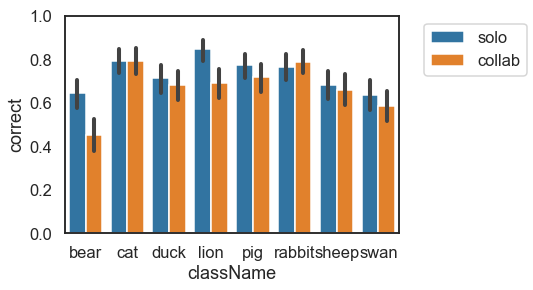

In [6]:
# M.groupby(['condition','className'])['correct'].mean()
sns.set_context('talk')
g = sns.barplot(data=M,
                x='className',
                hue='condition',
                y='correct',
                order=tuple(['bear', 'cat', 'duck', 'lion', 'pig', 'rabbit', 'sheep', 'swan']))
plt.ylim(0,1)
l = plt.legend(bbox_to_anchor=[1.05,1])

### construct confusion matrix

In [20]:
class_list = np.array(['bear', 'cat', 'duck', 'lion', 'pig', 'rabbit', 'sheep', 'swan'])

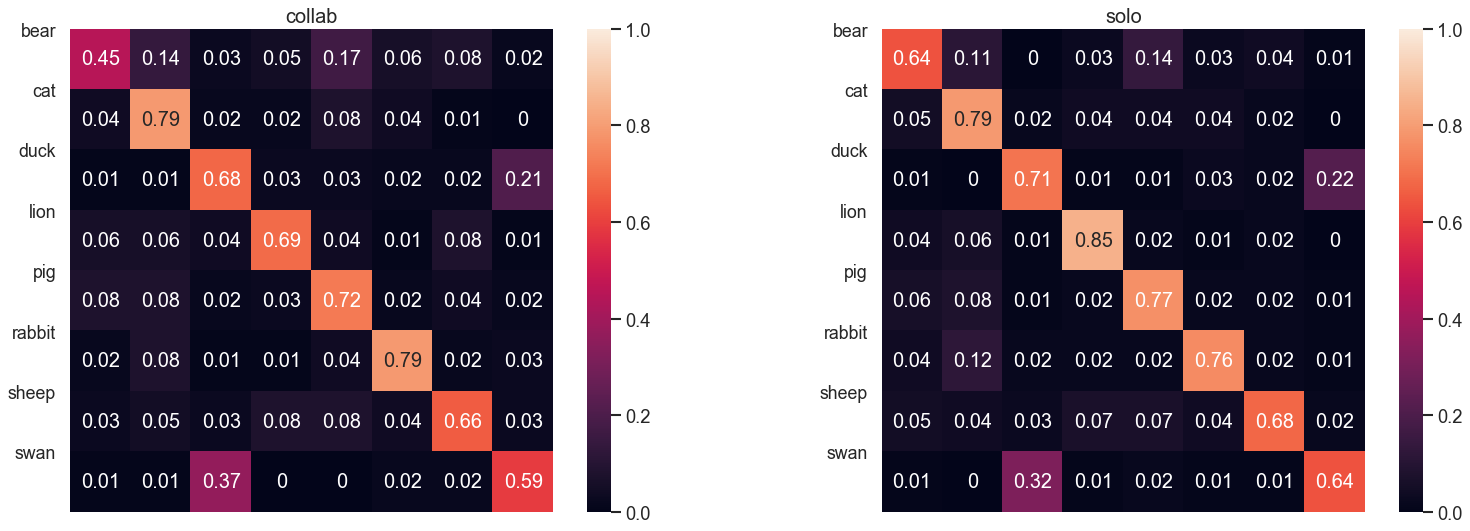

In [34]:
reload(h)
Confusion, Norm = h.compute_confusion_matrix(M,class_list,groupby=['condition'])

### Various performance statistics by condition

#### F1 score

In [9]:
from sklearn.metrics import f1_score
for name,group in M.groupby(['condition']):
    y_true = group['className'].values
    y_pred = group['response'].values
    print 'For {}, F1 score is {}.'.format(name, f1_score(y_true, y_pred, average='weighted').round(4))

For collab, F1 score is 0.6704.
For solo, F1 score is 0.7325.


#### correlation between confusion matrices

In [10]:
r,p = stats.spearmanr(np.ravel(Norm['collab']),np.ravel(Norm['solo']))
print 'Spearman r = {}'.format(r.round(4))

r,p = stats.pearsonr(np.ravel(Norm['collab']),np.ravel(Norm['solo']))
print 'Pearson r = {}'.format(r.round(4))

Spearman r = 0.8416
Pearson r = 0.9895


In [11]:
## TODO: compare to split-half reliability within condition, Spearman-Brown corrected

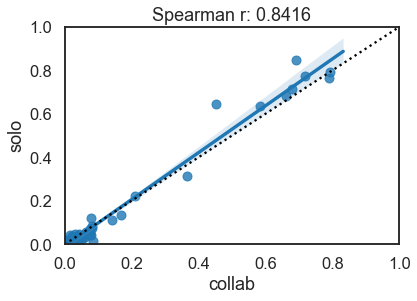

In [12]:
c = np.ravel(Norm['collab'])
s = np.ravel(Norm['solo'])
plt.title('Spearman r: {}'.format(stats.spearmanr(c,s)[0].round(4)))
s = sns.regplot(c,s)
plt.xlabel('collab')
plt.ylabel('solo')
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot((0,1),(0,1),'k:')

#### D-prime across categories

In [13]:
reload(h)
dc = h.dprime(Confusion['collab'],mode='confusionmat')
ds = h.dprime(Confusion['solo'],mode='confusionmat')

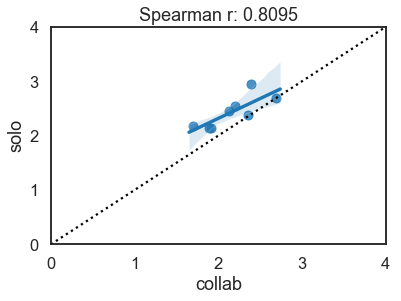

In [14]:
## plot d-prime between conditions
sns.set_context('talk')
plt.title('Spearman r: {}'.format(stats.spearmanr(dc,ds)[0].round(4)))
s = sns.regplot(dc,ds)
plt.xlabel('collab')
plt.ylabel('solo')
ub = 4
plt.xlim(0,ub)
plt.ylim(0,ub)
plt.plot((0,ub),(0,ub),'k:')

### link VGG predictions to empirical human recognition

In [15]:
## load in VGG predictions
V = pd.read_csv(os.path.join(csv_dir,'collabdraw_preds.csv'))

## subset to get just sketches in VGG pred df that are represented in recog dataframe M
V2 = V[V['sketch_id'].isin(M['sketch_id'].values)]
assert V2.sketch_id.nunique()==M.sketch_id.nunique()

## assign new column to M containing vgg predictions
vpd = dict(zip(V2['sketch_id'],V2['predClass'])) ## construct new dictionary
M = M.assign(vgg_pred = M['sketch_id'].apply(lambda x: vpd[x])) ## use dictionary to lookup fast

In [16]:
## get VGG confusion matrices by condition
Confusion_vgg, Norm_vgg = compute_confusion_matrix(M,class_list,
                                           groupby=['condition'],
                                           prediction='vgg_pred')

NameError: name 'compute_confusion_matrix' is not defined

In [ ]:
r,p = stats.spearmanr(np.ravel(Norm_vgg['collab']),np.ravel(Norm_vgg['solo']))
print 'Spearman r = {}'.format(r.round(4))

r,p = stats.pearsonr(np.ravel(Norm_vgg['collab']),np.ravel(Norm_vgg['solo']))
print 'Pearson r = {}'.format(r.round(4))

In [ ]:
dc = h.dprime(Confusion_vgg['collab'],mode='confusionmat')
ds = h.dprime(Confusion_vgg['solo'],mode='confusionmat')

In [ ]:
## plot d-prime between conditions
plt.title('Spearman r: {}'.format(stats.spearmanr(dc,ds)[0].round(4)))
s = sns.regplot(dc,ds)
plt.xlabel('collab')
plt.ylabel('solo')
ub = 2.5
plt.xlim(0,ub)
plt.ylim(0,ub)
plt.plot((0,ub),(0,ub),'k:')

#### correspondence between VGG and human dprimes?

In [ ]:
## get human and vgg confusion matrices, NOT breaking out by condition
### pass in "dummy" `grouping variable, iterationName
CV, NV = compute_confusion_matrix(M,class_list,
                                           groupby=['iterationName'],
                                           prediction='vgg_pred')

CH, NH = compute_confusion_matrix(M,class_list,
                                           groupby=['iterationName'],
                                           prediction='response')

In [ ]:
dv = h.dprime(CV['pilot0'],mode='confusionmat')
dh = h.dprime(CH['pilot0'],mode='confusionmat')

In [ ]:
sns.regplot(dv,dh)
ub = 3
plt.xlim(0,ub)
plt.ylim(0,ub)
plt.xlabel('VGG')
plt.ylabel('human')
t = plt.title('dprime')

In [ ]:
sns.regplot(np.ravel(CV['pilot0']),np.ravel(CH['pilot0']))
ub = 400
plt.xlim(0,ub)
plt.ylim(0,ub)
plt.xlabel('VGG')
plt.ylabel('human')
sr = stats.spearmanr(np.ravel(CV['pilot0']),np.ravel(CH['pilot0']))[0].round(4)
t = plt.title('Spearman r: {}'.format(sr))